In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(session.query(func.max(Measurement.date)).scalar()) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
print(one_year_ago) 

2016-08-23


In [11]:

# Perform a query to retrieve the date and precipitation scores
recent_yearly_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= (pd.to_datetime(session.query(func.max(Measurement.date)).\
    scalar()) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')).all()


Text(0, 0.5, 'Precipitation (Inches)')

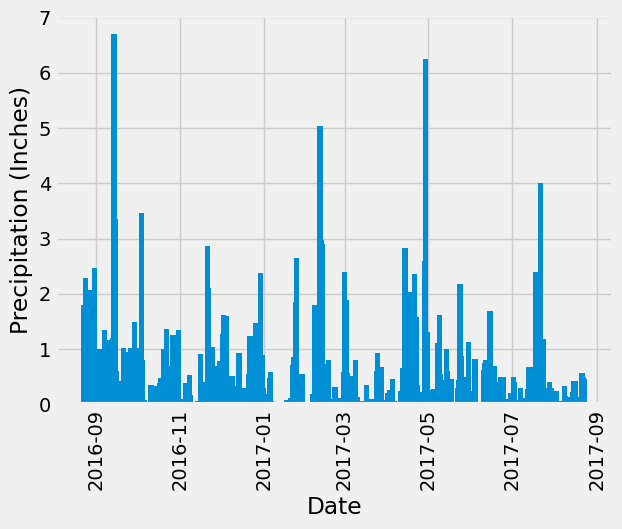

In [12]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(recent_yearly_prcp, columns=['date', 'precipitation'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

plt.bar(df['date'], df['precipitation'], width=3.8)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

for station, count in station_count:
    print(f'{station}, {count}')

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [16]:
# Save station name to a variable for future referencing
# mas stands for 'most active station'
mas = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).first()
mas_name = mas[0]
print(mas_name)

USC00519281


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, # Added for further clarity
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active = session.query(*sel).\
    filter(Measurement.station == f'{mas_name}').all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

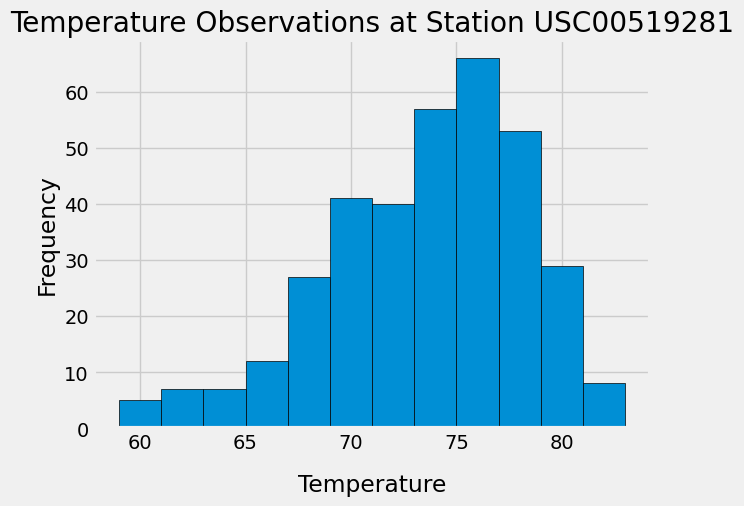

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == f'{mas_name}').\
    filter(Measurement.date >= (pd.to_datetime(session.query(func.max(Measurement.date)).\
    scalar()) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')).all()

# Save the query results as a Pandas DataFrame
station_temp_df = pd.DataFrame(station_temp, columns=['date', 'tobs'])

plt.hist(station_temp_df['tobs'], bins=12, edgecolor='black') # Add edgecolor for clarity
plt.xlabel('Temperature', labelpad=15)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations at Station {mas_name}')
plt.show()

# Close Session

In [22]:
# Close Session
session.close()